# Homework 2 from Martin Gräf, Richard Baumann and Thomas Block

## Exercise 1

After taking a look at the one-dimensional ising model in Homework 1, we now take a look at the two-dimensional variant. Again we have the hamiltonian:


\begin{equation}
    H(\sigma) = - J \sum_{\langle x~y\rangle} \sigma_x \sigma_y - h \sum_x \sigma_x
\end{equation}





In [1]:
#just importing stuff, nothing to see here yet :)

import numpy as np 
import random as rd
import matplotlib.pyplot as plt
import math
import itertools 
import scipy.special as sp

This time we not only look at the particles left and right of the observed particle, but at the particles above and below. Therefore the hamiltonian for a spin at position $(x,y)$ looks like this:

\begin{equation}
    H(\sigma_{x,y}) = - J (\sigma_{x-1, y} \sigma_{x, y} + \sigma_{x+1, y} \sigma_{x, y} + \sigma_{x, y-1} \sigma_{x, y} + \sigma_{x, y+1} \sigma_{x, y}) - h \sigma_{x, y}
\end{equation}

As we can see in the equation above, this hamiltonian looks at all adjacent spins. Therefore, the implementation looks something like that:


In [2]:
#Spin is supposed to be a NxN big array. Position has to be an array of the form [x, y] to indicate the position of the spin.
def hamiltionian(spin_array, position, j, h):
    minuend=0
    if position[0]+1 < len(spin_array[0])-1:
        minuend = minuend + spin_array[position[0]+1][position[1]] * spin_array[position[0]][position[1]] \
                          + spin_array[position[0]-1][position[1]] * spin_array[position[0]][position[1]]
    else:
        minuend = minuend + spin_array[position[0]-1][position[1]] * spin_array[position[0]][position[1]] \
                          + spin_array[0][position[1]] * spin_array[position[0]][position[1]] 
    
    if position[1]+1 < len(spin_array[0])-1:
        minuend = minuend + spin_array[position[0]][position[1]+1] * spin_array[position[0]][position[1]]  \
                          + spin_array[position[0]][position[1]-1] * spin_array[position[0]][position[1]] 
    else:
        minuend = minuend + spin_array[position[0]][position[1]-1] * spin_array[position[0]][position[1]]  \
                          + spin_array[position[0]][0] * spin_array[position[0]][position[1]]
        
    return (-j*minuend-h*spin_array[position[0]][position[1]])

Now we have to generate a spin array, that can be used later on. This array has to be two dimensional. This spin-arry is $ N_{x} $ x $ N_{y} $ large, however in accordance to the exercise sheet we choose $ N_{x}=N_{y} $.

In [3]:
def gen_spin_array(length):
    configurations=np.zeros(length*length).reshape(length, length)
    current_configuration=np.zeros(length)
    for j in range(length):
        for i in range(length):
            #a random integer between 1 and 3 (1, 2)
            current_configuration[i]=(2*rd.randint(1, 2)-3)
        configurations[j]=current_configuration
    return configurations

In [4]:
#configs = gen_spin_array(10)
#print(configs)
#print(configs[0][2])


We can carry over the other instructions from the previous homework. Therefore, we assume, that the spins are distributed following a Bolzmann distribution (a fact, that is given by the exercise sheet):

\begin{equation}
    P(s)=\frac{ exp \big[-\frac{H(s)}{k_{b}T} \big]}{\sum_{s`} exp \big[-\frac{H(s`)}{k_{b}T}\big]}  = \frac{1}{Z} exp \big[-\frac{H(s)}{k_{b}T} \big].
\end{equation}

Thus, Z can be determined via:

\begin{equation}
    Z={\sum_{s`} exp \big[-\frac{H(s`)}{k_{b}T}\big]} 
\end{equation}

In [5]:
def z_simulated(spin_array, j, h, t):
    sum=0
    for k in range(len(spin_array[0])):
        for l in range(len(spin_array[0])):
            sum=sum+np.exp(-hamiltionian(spin_array, [k, l], j, h)/t)
    return (sum)

In [6]:
#z_simulated(configs, 0.5, 0.8, 0.5)

And, the magnetization per spin is defined as:

\begin{equation}
    <m>=+\frac{T}{N}\frac{\partial log(Z)}{\partial h} 
\end{equation}

In [7]:
def magnetization_random_configurations(spin_array, j, h, t, intervall):
    z_1=z_simulated(spin_array, j, h+(intervall/2), t)
    z_2=z_simulated(spin_array, j, h-(intervall/2), t)
    return (t/(len(spin_array[0])**2)*((np.log(z_1)-np.log(z_2))/intervall))

In [8]:
#magnetization = magnetization_random_configurations(configs, 0.03, 2, 0.5, 0.5)
#print(magnetization)

Here comes the part that is different to the last homework. Instead of brute forcing the solution we now have a plan. We will use the Metropolis-Hastings Method:

* **1. We take a random spin from our matrix** 

<space>

* **2. Then we flip the spin ($s_{i}=-1*s_{i}$)**

<space>

* **3.  The change in energy is calculated**
    
<space>   
    
* **4.  Actual Metropolis-Hastings step:**
    
    <space><space>
        
    * A if $\Delta S < 0 $ ACCEPT the spin flip
    
    <space><space>
        
    * B else sample y ~ U(0,1)
         
         <space><space>
         
         * if y $\leq exp(-\Delta S)$ ACCEPT the spin flip
           
         <space><space>    
             
         * otherwise REJECT the spin flip and keep the original spin $s_{i}$
             
         <space><space>
    
<space>
    
* **5. Steps 1-4 are repeated for $\Lambda$ times (which is called sweep)**

First we will implement a sweep. One thing to mention is, that sampling over a uniform distribution as written above can slow down the algorihm. Importance sampling is much better for a problem like this.

In [9]:
def sweep(spin_array, j, h, t):
    
    #Choose a random position
    x = rd.randint(0, len(spin_array[0])-1)
    y = rd.randint(0, len(spin_array[0])-1)
    
    # If we reach borders, we return on the other side of the problem.
    # Negative index (-1) ends up at the end of array
    # End of array needs to be taken care of 
    # i = l = -1
    if x == len(spin_array[0]) - 1:
        x = -1
    if y == len(spin_array[0]) - 1:
        y = -1
    #print(x, y)
    
    #Calculate Energy prior to flip
    # Therefore we don't have to sum over the whole grid
    # Those are the only contributions to change in energy
    s_prior = (hamiltionian(spin_array, [x, y], j, h) + \
              hamiltionian(spin_array, [x+1, y], j, h) + \
              hamiltionian(spin_array, [x, y+1], j, h) + \
              hamiltionian(spin_array, [x-1, y], j, h) + \
              hamiltionian(spin_array, [x, y-1], j, h)) / t 
    
    #Flip Spin
    spin_array[x, y] = -spin_array[x, y]
    
    #Calculate Energy after flip
    s_later = (hamiltionian(spin_array, [x, y], j, h) + \
              hamiltionian(spin_array, [x+1, y], j, h) + \
              hamiltionian(spin_array, [x, y+1], j, h) + \
              hamiltionian(spin_array, [x-1, y], j, h) + \
              hamiltionian(spin_array, [x, y-1], j, h))/t 
    
    #Computing the Energy
    delta_s = s_later - s_prior
    
    if delta_s <= 0:
        return(spin_array)
    else:
        y = rd.randint(0, 1)
        # allow small increasing energy
        if y > math.exp(-delta_s):
            # if energy too high, flip again the spin to keep
            # original configuration
            spin_array[x, y] = -spin_array[x, y]
            
        return(spin_array)


Now these sweeps are executed a lot of times. The next steps are:

+ **6. Measure the a relevant property (magnetization, internal energy, etc.)**

<space>
    
* **7. Repeat from step 1 (Over time magnetization should converge towards the real value of the observable)**

In [10]:
def mc_estimate(spin_array, j, h, t, lamba, repeats):
    m=np.zeros(repeats)
    
    for k in range(repeats):
        for i in range(int(lamba)):
            spin_array = sweep(spin_array, j, h, t)
        m[k] = magnetization_random_configurations(spin_array, j, h, t, 0.01)
        #print(m[k])
        #print(m)
        
    return np.average(m)

In [11]:
#mc_estimate(configs, -0.8, 0.8, 1, len(configs[0])**2, 100) # Lambda is the amount of elements, so here NxN

## Exercise 2

**How does the numerical cost of the calculation of the energy (for a given spin configuration) scale with the system size $\Lambda$ ?**

<space>

Since we sum over all spins, we use for each spin only one execution of our function *hamiltonian*, where the energy of the spin in the magnetic field *H* and the coupling energy of the spin to its neighbors is calculated. So the numerical cost is roughly $\propto \Lambda$, where $\Lambda$ is the number of spins in our grid.

## Exercise 3

**Assuming you’ve flipped one spin $s_{i}$, how does the numerical cost of the calculation of the change in energy $\Delta S$ scale with the system size $\Lambda$ ?**

<space>

We take only the Hamiltonians, which are changed due to the spin flip. We execute the function *hamiltonian* for the calculation of $\Delta S$ only a set number of times, that is only the Hamiltonians for which we now changed energy. So the numerical cost for $\Delta S$ is not dependent on $\Lambda$, but rather constant.

## Exercise 4

**What is the significance of the critical coupling $J_c$ ?**

<space>

The critical coupling is the value for the ratio of coupling strength to temperature, under which spontaneous symmetry breaking happens. In this case (parts of the) spins, although not influenced by an external field, start to align, such that the average magnetization is not zero anymore. This happens at suffenciently large J or low temperatures. A phase transition happens.

## Exercise 5

Now we can look at how the magnetization changes when the relevant parameters change. We choose different N-values and just see how m is dependent on h.

$h \in [-1, 1]$

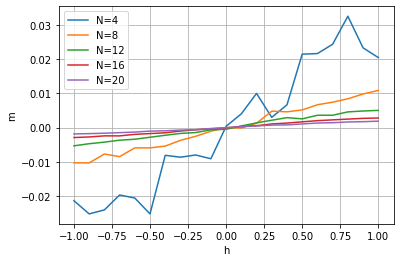

In [12]:
#def plot_m_h_dependency(j, t, lamba, repeats):
def plot_m_h_dependency(j, t, repeats):
    h_array=np.arange(-1, 1.01, 0.1)
    m_array_4=np.zeros(len(h_array))
    m_array_8=np.zeros(len(h_array))
    m_array_12=np.zeros(len(h_array))
    m_array_16=np.zeros(len(h_array))
    m_array_20=np.zeros(len(h_array))
    for i in range(len(h_array)):
        m_array_4[i]=mc_estimate(gen_spin_array(4), j, h_array[i], t, 4**2, repeats)
        m_array_8[i]=mc_estimate(gen_spin_array(8), j, h_array[i], t, 8**2, repeats)
        m_array_12[i]=mc_estimate(gen_spin_array(12), j, h_array[i], t, 12**2, repeats)
        m_array_16[i]=mc_estimate(gen_spin_array(16), j, h_array[i], t, 16**2, repeats)
        m_array_20[i]=mc_estimate(gen_spin_array(20), j, h_array[i], t, 20**2, repeats)
    plt.plot(h_array, m_array_4, label="N=4")
    plt.plot(h_array, m_array_8, label="N=8")
    plt.plot(h_array, m_array_12, label="N=12")
    plt.plot(h_array, m_array_16, label="N=16")
    plt.plot(h_array, m_array_20, label="N=20")
    plt.legend(loc="best")
    plt.xlabel("h")
    plt.ylabel("m")
    plt.grid('True')
    plt.savefig("h_m_dependency.png")

plot_m_h_dependency(1, 1, 100)    
#plot_m_h_dependency(1, 1, 49, 100)

## Exercise 6

It is also interesting to take a look, at the average energy per site. An analytical solution for that is given by:
\begin{equation}
    \epsilon=−J \coth (2J) (1 + \frac{2}{\pi} (2 \tanh^2(2J)−1)K(4sech^2(2J) tanh^2(2J)))
\end{equation}

With K beeing the incomplete elliptic integral of the first kind. This can be calculated by using the formula

\begin{equation}
    F(x ; k) = \int_{0}^{x} \frac{\mathrm{d}t}{\sqrt{\left(1 - t^2\right)\left(1 - k^2 t^2\right)}}
\end{equation}

This formula could be implemented by hand, however in the package scipy we have the function scipy.special.ellipkinc, which calculates the incomplete elliptic integral of the first kind. We only look at a certain j intervall: $j \in [0.25, 1]$.

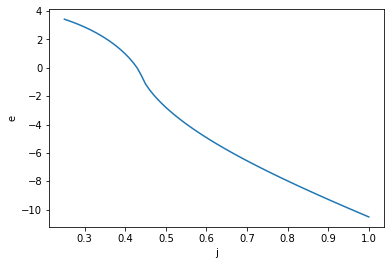

In [13]:
def mean_energy_analytical(j):
    spherical=sp.ellipkinc(math.pi/2, 4*math.cosh(2*j)**-2*math.tanh(2*j)**2)
    return (-j*(math.cosh(2*j)/math.sinh(2*j))*(1+2*math.pi*(2*math.tanh(2*j)**2-1)*spherical))

def plot_mean_energy(N, h, t, lamba, repeats):
    j_array=np.arange(0.25, 1.01, 0.01)
    mean_energy_array=np.zeros(len(j_array))
    for i in range(len(j_array)):
        mean_energy_array[i]=mean_energy_analytical(j_array[i])
    plt.plot(j_array, mean_energy_array)
    plt.xlabel("j")
    plt.ylabel("e")
    plt.savefig("plot_mean_energy.png")

plot_mean_energy(4, 1, 1, 1, 1)

## Exercise 7

We can also calculate an analytical solution for absolute value of the mean magnetization. This is given by:

\begin{equation}
        |m| = \left\{
		\begin{array}{ll}
		\left(\frac{1}{\sinh^4(2J)}\right)^{\frac{1}{8}}, &\text{ if }J_c < J \\
		0 & else 
		\end{array}
		\right.
\end{equation}

We can compare this to our simulated result. For the comparison we only look a certain J interval. 

$j \in [0.25, 1]$

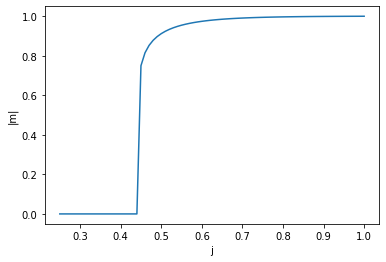

In [14]:
def mean_magnetization_analytical(j):
    if j>0.440686793509772:
        return ((1-(1/(math.sinh(2*j)**4)))**(1/8))
    else:
        return 0

def plot_mean_magnetization(N, h, t, lamba, repeats):
    j_array=np.arange(0.25, 1.01, 0.01)
    mean_magnetization_array=np.zeros(len(j_array))
    for i in range(len(j_array)):
        mean_magnetization_array[i]=mean_magnetization_analytical(j_array[i])
    plt.plot(j_array, mean_magnetization_array)
    plt.xlabel("j")
    plt.ylabel("|m|")
    plt.savefig("plot_mean_energy.png")

plot_mean_magnetization(4, 1, 1, 1, 1)